In [ ]:
from pathlib import Path
import os

os.environ['LANDSLIDE_DENSITY_THRESHOLD'] = (
    '0.0000001'  # the percentage landslide required for an image to be classified as landslided (check landnet.config module)
)

from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    RandomCAM,
    LayerCAM,
    GradCAMElementWise,
    EigenGradCAM,
    GuidedBackpropReLUModel,
)
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUasModule
from pytorch_grad_cam.utils.image import (
    show_cam_on_image,
    deprocess_image,
    preprocess_image,
)
from pytorch_grad_cam.utils.find_layers import replace_all_layer_type_recursive
from pytorch_grad_cam.utils.model_targets import (
    BinaryClassifierOutputTarget,
    ClassifierOutputTarget,
)
from pytorch_grad_cam.metrics.road import ROADCombined
from torch import nn
import numpy as np
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import clear_output
from sklearn.decomposition import PCA

from landnet.config import MODELS_DIR, FIGURES_DIR
from landnet.enums import Mode, GeomorphometricalVariable, Architecture
from landnet.modelling import torch_clear
from landnet.modelling.classification.lightning import LandslideImageClassifier
from landnet.modelling.classification.models import get_architecture
from landnet.modelling.classification.dataset import (
    ConcatLandslideImageClassification,
    LandslideImageClassification,
)
from landnet.features.grids import get_grid_for_variable
from landnet.features.tiles import TileConfig, TileSize
from landnet.modelling.dataset import get_default_transform
from landnet.typing import TuneSpace

clear_output()

In [ ]:
checkpoint = (
    MODELS_DIR
    / 'convnext_100x100_10vars/convnext_100x100_10vars/TorchTrainer_cf20a57d_5_batch_size=4,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-28_00-30-26/checkpoint_000016/checkpoint.ckpt'
)
model_name = checkpoint.relative_to(MODELS_DIR).parents[-2].name
assert checkpoint.exists()
variables_path = checkpoint.parent.parent.parent / 'geomorphometrical_variables'
assert variables_path.exists()

tile_config = TileConfig(TileSize(100, 100), overlap=0)
model_config: TuneSpace = {
    'batch_size': 1,
    'learning_rate': 0.000001,
    'tile_config': tile_config,
}

variables = GeomorphometricalVariable.parse_file(variables_path)

In [7]:
grids = {}
datasets = {}

# for mode in (Mode.TRAIN, Mode.TEST, Mode.VALIDATION):
for mode in (Mode.TEST,):
    grids[mode] = [
        get_grid_for_variable(
            variable,
            tile_config=tile_config,
            mode=mode,
        )
        for variable in variables
    ]
    dataset = ConcatLandslideImageClassification(
        landslide_images=[
            LandslideImageClassification(
                grid,
                mode,
                transform=get_default_transform(),
            )
            for grid in grids[mode]
        ],
        augment_transform=None,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        num_workers=4,
        shuffle=False,
        prefetch_factor=4,
        persistent_workers=True,
        pin_memory=True,
    )
    datasets[mode] = list(dataloader)

clear_output()

In [8]:
def get_all_conv2d_layers(model):
    conv_layers = {}

    def recurse(module, prefix=''):
        for name, layer in module.named_children():
            full_name = f'{prefix}.{name}' if prefix else name
            if isinstance(layer, nn.Conv2d):
                conv_layers[full_name] = layer
            elif isinstance(layer, nn.Module):  # If it's a module, recurse
                recurse(layer, full_name)

    recurse(model)
    return conv_layers


def save_activations_and_gradients(
    cam, out_dir: Path, index: int = 0, count: int = 50, split: bool = True
):
    os.makedirs(out_dir, exist_ok=True)
    activations = cam.activations_and_grads.activations[index].squeeze(0)
    gradients = cam.activations_and_grads.gradients[index].squeeze(0)
    for matrices, name, cmap in zip(
        (activations, gradients),
        ('activations', 'gradients'),
        ('viridis', 'Grays'),
    ):
        num_channels = matrices.shape[0]
        num_arrs = min(count, num_channels)
        for i, matrix in enumerate(matrices):
            fig, ax = plt.subplots()
            if i > num_arrs:
                break
            arr = matrix.cpu().numpy()
            ax.imshow(arr, cmap=cmap)
            ax.axis('off')  # Hide axis
            plt.tight_layout()
            plt.savefig(
                out_dir / f'{name}_{i}_{matrix.shape}.png',
                dpi=300,
                transparent=True,
                bbox_inches='tight',
                pad_inches=0,
            )
            plt.close()


class BinaryGuidedBackpropReLUModel(GuidedBackpropReLUModel):
    def __init__(self, model, device):
        super().__init__(model, device)

    def __call__(self, input_img):
        replace_all_layer_type_recursive(
            self.model, nn.ReLU, GuidedBackpropReLUasModule()
        )

        input_img = input_img.to(self.device)

        input_img = input_img.requires_grad_(True)

        loss = self.forward(input_img)
        loss.backward(retain_graph=True)

        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]
        output = output.transpose((1, 2, 0))

        replace_all_layer_type_recursive(
            self.model, GuidedBackpropReLUasModule, nn.ReLU()
        )

        return output


def get_guided_backprop(classifier, input_tensor, cam):
    gb_model = BinaryGuidedBackpropReLUModel(
        model=classifier, device=classifier.device
    )
    gb = gb_model(input_tensor)
    cam_mask = np.repeat(np.expand_dims(grayscale_cam, 2), gb.shape[2], 2)
    cam_gb = deprocess_image(cam_mask * gb)
    return cam_gb[:, :, :3]


class LogitBinaryClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        model_output = model_output.sigmoid()
        if self.category == 1:
            sign = 1
        else:
            sign = -1
        return model_output * sign

In [9]:
torch_clear()

classifier = LandslideImageClassifier.load_from_checkpoint(
    checkpoint,
    model=get_architecture(Architecture('convnext'))(
        len(variables), Mode.INFERENCE
    ),
)

DEBUG: Adapting model input channels from 10 to 3




KeyboardInterrupt

███████████████████████████| 32/32 [00:25<00:00,  1.26it/s]

Error in callback <function _draw_all_if_interactive at 0x79e6dfe9dda0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

/home/alex/miniforge3/envs/landnet/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


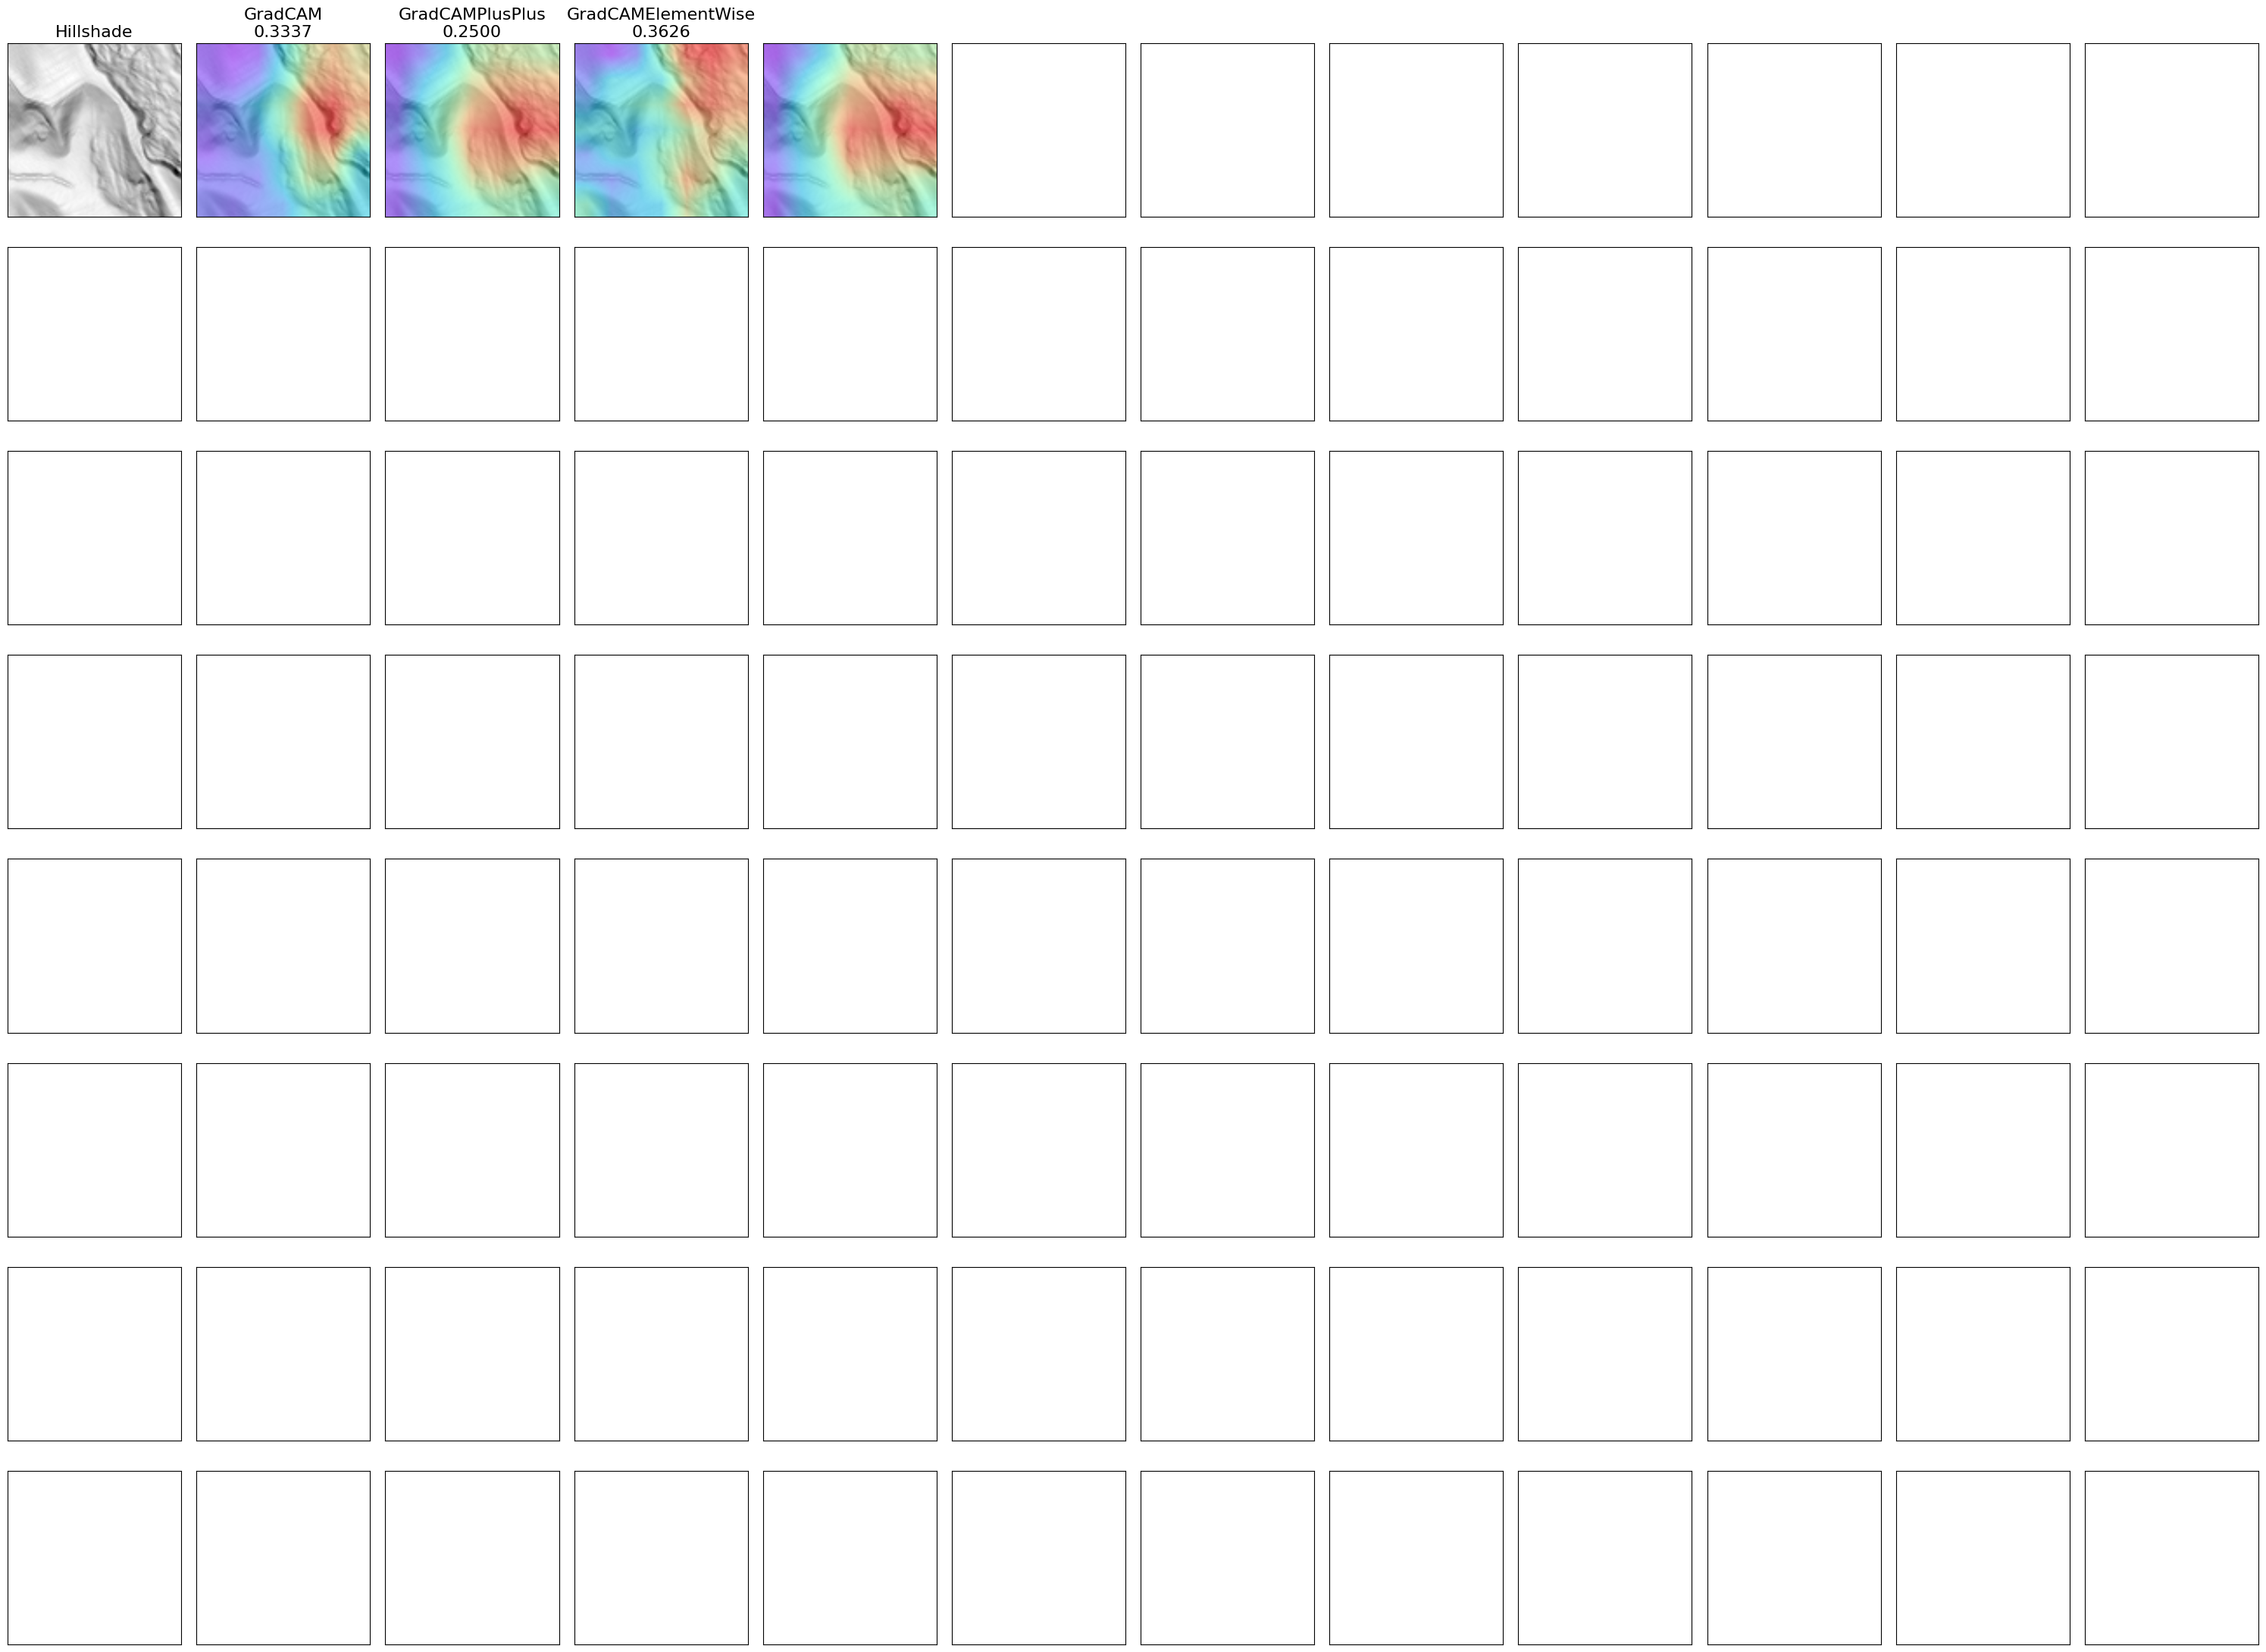

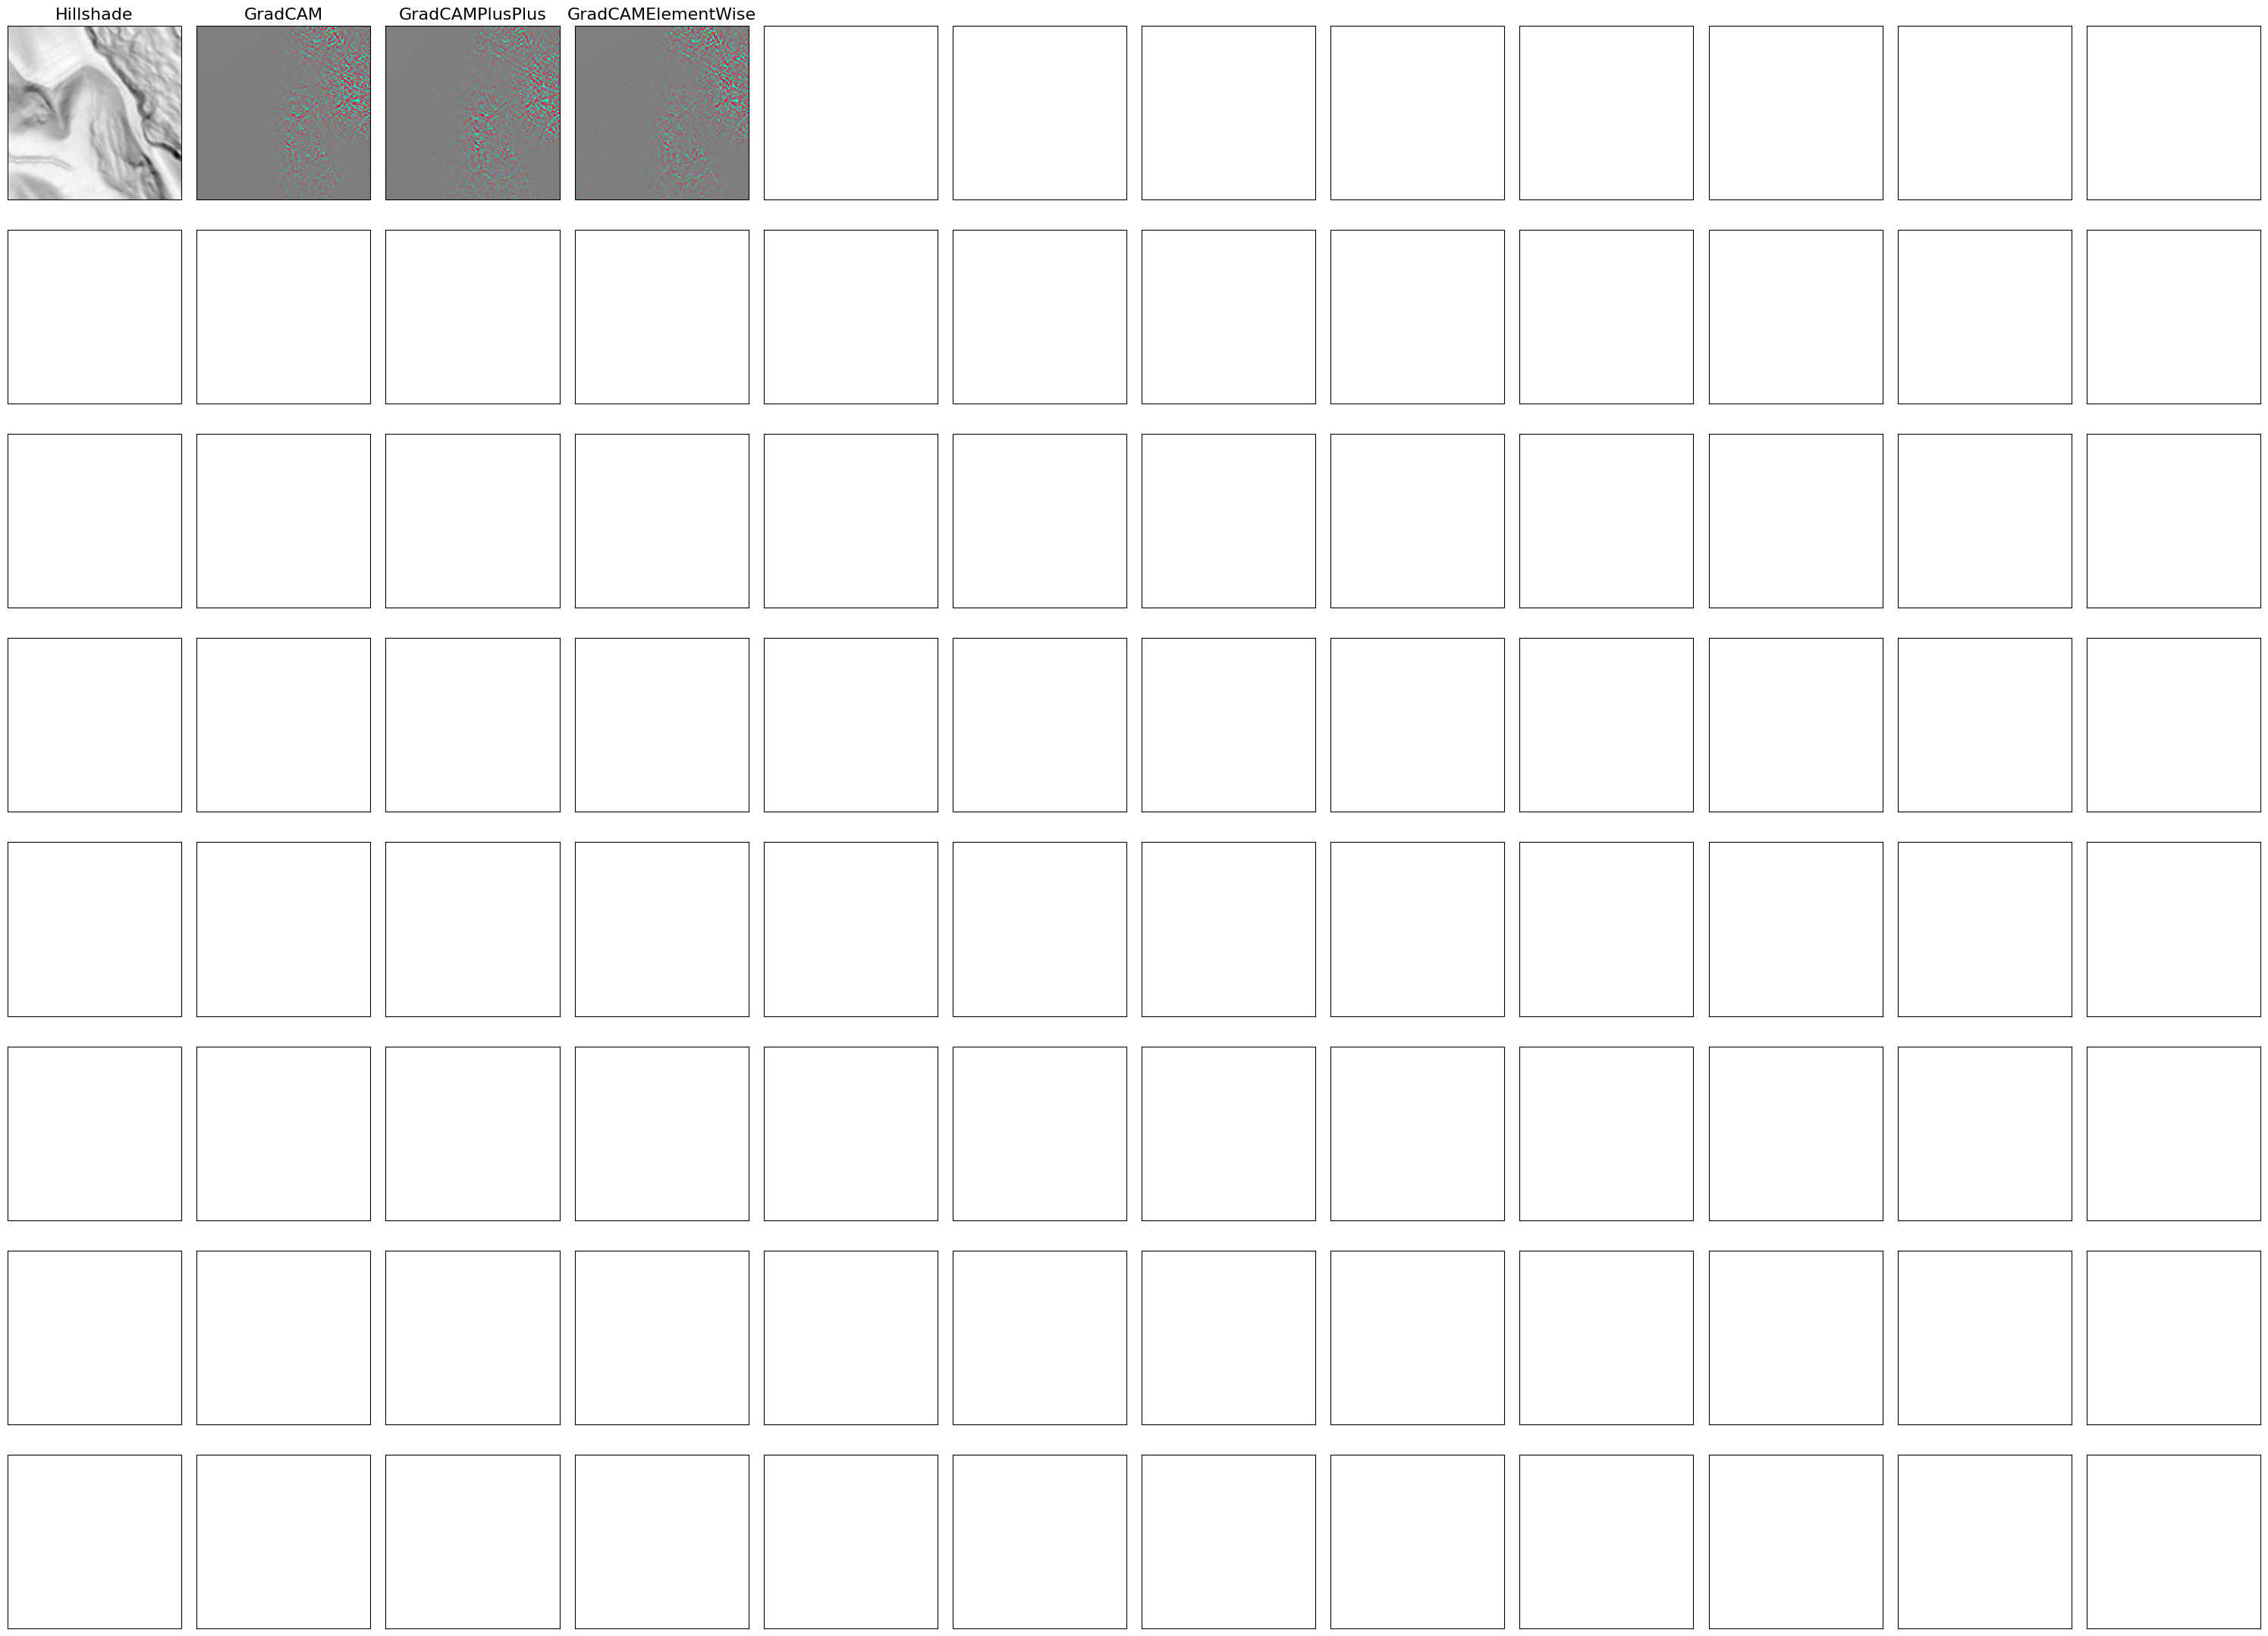

In [7]:
# Compares different GradCAM methods

methods = [
    GradCAM,
    GradCAMPlusPlus,
    GradCAMElementWise,
    AblationCAM,
    ScoreCAM,
    EigenCAM,
    LayerCAM,
    HiResCAM,
    XGradCAM,
    EigenGradCAM,
    RandomCAM,
]
# The index of the tiles to select from the test area

# Good examples
sample_indices = [297, 265, 392, 360, 241, 164, 90, 357]

# False negatives
# sample_indices = [379, 293, 121, 329, 363, 342]
n_samples = len(sample_indices)
n_methods = len(methods)
layers = get_all_conv2d_layers(classifier)

layer_names = list(layers)
layer_name = layer_names[-1]
layer = layers[layer_name]
target_layers = [layer]

grid_fig = plt.figure(figsize=(30.0, 30.0))
grid_fig.set_tight_layout(True)
guided_backprop_fig = plt.figure(figsize=(30.0, 30.0))
guided_backprop_fig.set_tight_layout(True)

guided_backprop_grid = ImageGrid(
    guided_backprop_fig,
    111,
    nrows_ncols=(n_samples, n_methods + 1),
    axes_pad=(0.2, 0.4),
    share_all=True,
)
grid = ImageGrid(
    grid_fig,
    111,
    nrows_ncols=(n_samples, n_methods + 1),
    axes_pad=(0.2, 0.4),
    share_all=True,
)
for grid_ in (guided_backprop_grid, grid):
    grid_[0].get_yaxis().set_ticks([])
    grid_[0].get_xaxis().set_ticks([])

fontdict = {'fontsize': 16}
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])

for i, sample_index in enumerate(sample_indices):
    hillshade = datasets[Mode.TEST][sample_index][0][0, 0].numpy()
    hillshade_index = i * (n_methods + 1)
    grid[hillshade_index].imshow(hillshade, cmap='binary')
    guided_backprop_grid[hillshade_index].imshow(hillshade, cmap='binary')

    if i == 0:
        grid[hillshade_index].set_title('Hillshade', fontdict=fontdict)
        guided_backprop_grid[hillshade_index].set_title(
            'Hillshade', fontdict=fontdict
        )

    results = {}
    for j, method in enumerate(methods, start=1):
        with method(model=classifier, target_layers=target_layers) as cam:
            input_tensor = datasets[Mode.TEST][sample_index][0].to(
                classifier.device
            )
            targets = [LogitBinaryClassifierOutputTarget(1)]
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            # save_activations_and_gradients(cam, out_dir=FIGURES_DIR / f'tile_{sample_index}' / layer_name)
            grayscale_cam = grayscale_cams[0, :]
            cam_index = hillshade_index + j
            grid[cam_index].imshow(hillshade, cmap='binary')
            grid[cam_index].imshow(grayscale_cam, cmap='rainbow', alpha=0.5)
            scores = cam_metric(
                input_tensor, grayscale_cams, targets, classifier
            )
            score = scores[0] * 100
            title = f'{scores[0]:.4f}'
            guided_backprop_cam = get_guided_backprop(
                classifier, input_tensor, grayscale_cam
            )
            guided_backprop_grid[cam_index].imshow(
                guided_backprop_cam, cmap='rainbow'
            )
            if i == 0:
                title = '\n'.join([method.__name__, title])
                guided_backprop_grid[cam_index].set_title(
                    method.__name__, fontdict=fontdict
                )
            grid[cam_index].set_title(title, fontdict=fontdict)

    # grid_fig.savefig(FIGURES_DIR / f'{model_name}_gradcams_10vars_{n_samples}.png', dpi=300, bbox_inches='tight')
    # guided_backprop_fig.savefig(FIGURES_DIR / f'{model_name}_guidedbackpropcam_10vars_{n_samples}.png', dpi=300, bbox_inches='tight')
# clear_output()
# plt.tight_layout()


/tmp/ipykernel_174630/383393122.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  grid_fig.savefig(FIGURES_DIR / 'guided_cam_example.png', dpi=300, bbox_inches='tight')


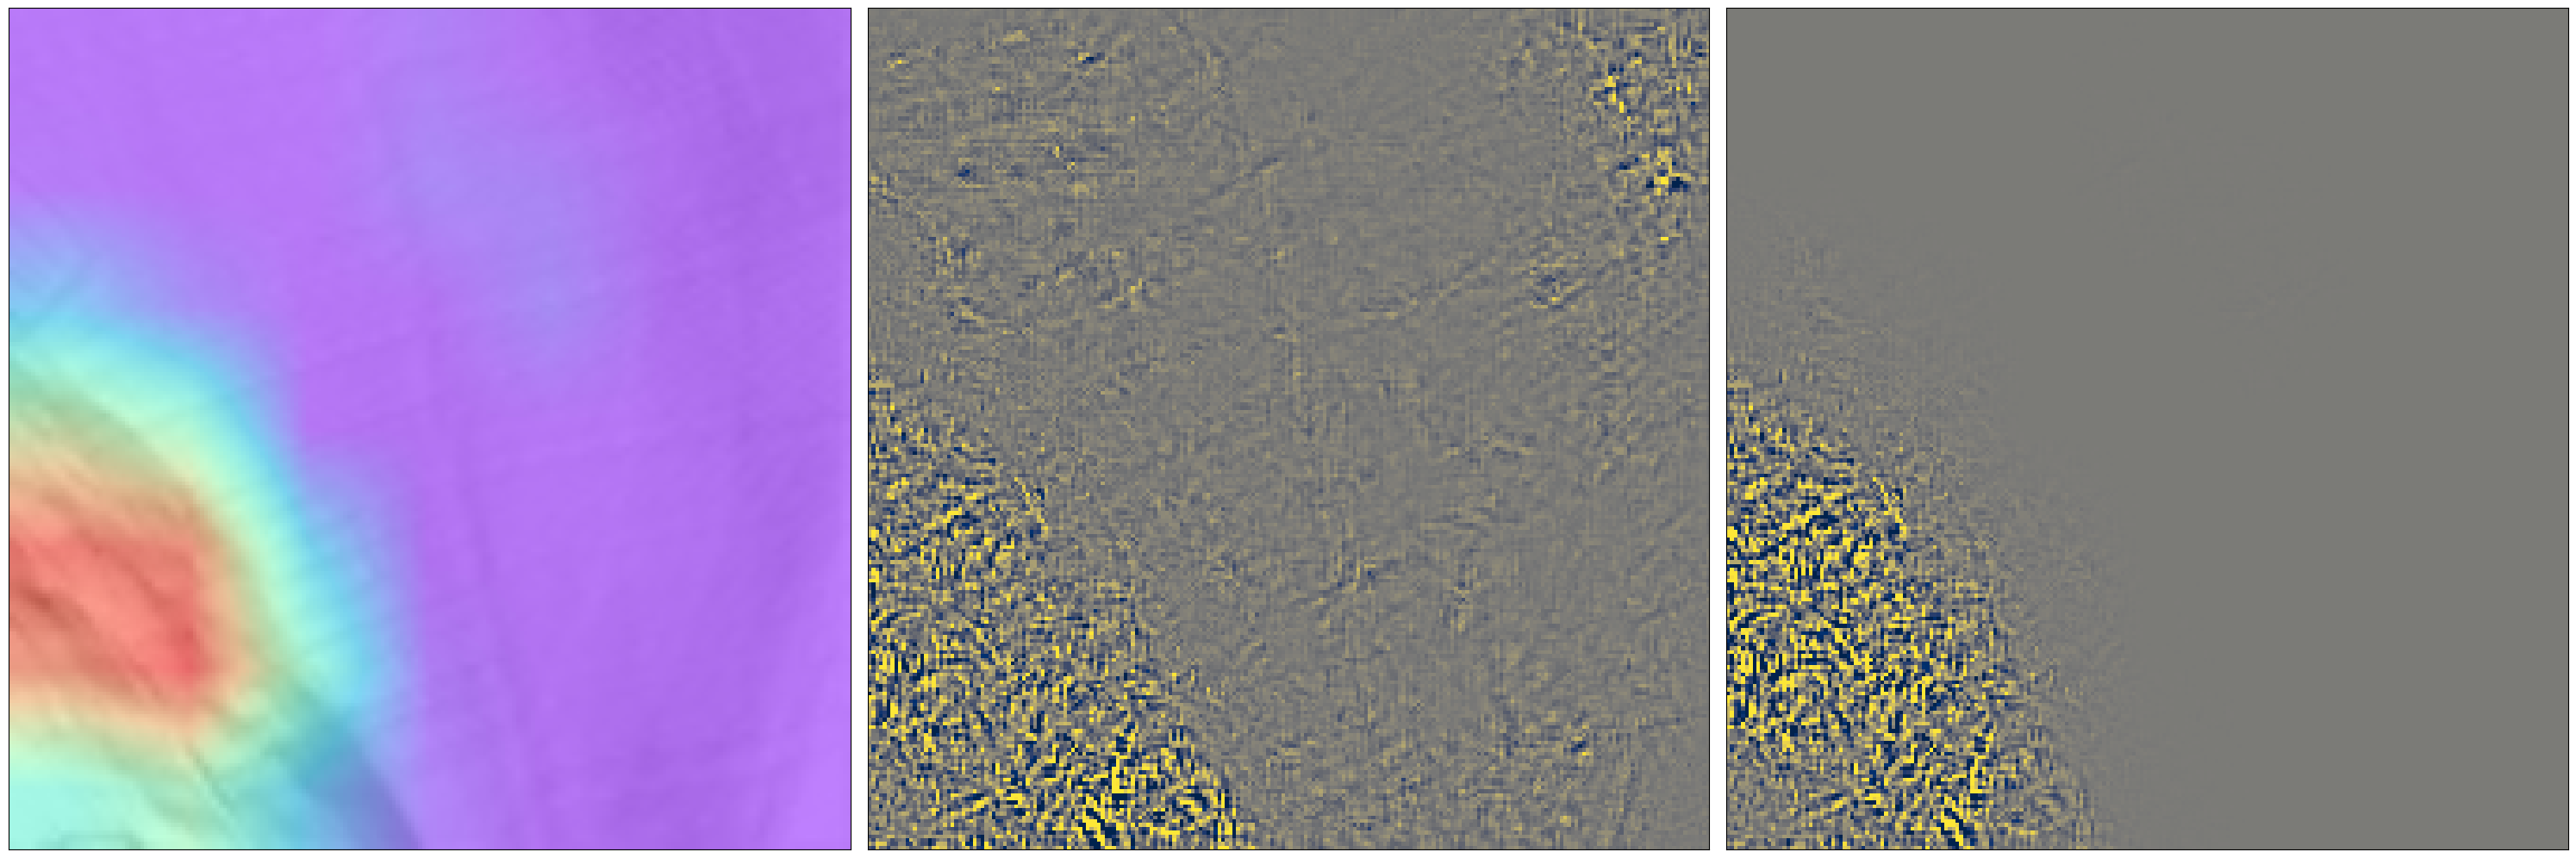

In [13]:
def get_guided_backprop(classifier, input_tensor, grayscale_cam):
    gb_model = BinaryGuidedBackpropReLUModel(
        model=classifier, device=classifier.device
    )
    gb = gb_model(input_tensor)
    cam_mask = np.repeat(np.expand_dims(grayscale_cam, 2), gb.shape[2], 2)
    cam_gb = deprocess_image(cam_mask * gb)
    return deprocess_image(gb)[:, :, :1], cam_gb[:, :, :1]


layers = get_all_conv2d_layers(classifier)

layer_names = list(layers)
layer_name = layer_names[-1]
layer = layers[layer_name]
target_layers = [layer]


method = ScoreCAM

sample_index = 353
sample = datasets[Mode.TEST][sample_index]
input_tensor = sample[0].to(classifier.device)
hillshade = sample[0][0, 0].numpy()

grid_fig = plt.figure(figsize=(30.0, 30.0))
grid_fig.set_tight_layout(True)

grid = ImageGrid(
    grid_fig,
    111,
    nrows_ncols=(1, 3),
    axes_pad=(0.2, 0.4),
    share_all=True,
)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
with method(model=classifier, target_layers=target_layers) as cam:
    targets = [LogitBinaryClassifierOutputTarget(1)]
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    # save_activations_and_gradients(cam, out_dir=FIGURES_DIR / f'tile_{sample_index}' / layer_name)
    grayscale_cam = grayscale_cams[0, :]
    gb, cam_gb = get_guided_backprop(classifier, input_tensor, grayscale_cam)
    grid[0].imshow(hillshade, cmap='binary', alpha=0.5)
    grid[0].imshow(grayscale_cam, cmap='rainbow', alpha=0.5)
    grid[1].imshow(gb, cmap='cividis')
    grid[2].imshow(cam_gb, cmap='cividis')

grid_fig.savefig(
    FIGURES_DIR / 'guided_cam_example.png', dpi=300, bbox_inches='tight'
)

In [ ]:
# Saves heatmaps as geotif to produce the GradCAM map

# torch_clear()

# classifier = LandslideImageClassifier.load_from_checkpoint(
#     checkpoint,
#     model=get_architecture(Architecture('convnext'))(
#         len(variables), Mode.INFERENCE
#     ),
# )

# method = GradCAMElementWise

# target_layers = classifier.model[-1].features[-1]

# for mode, tensors in datasets.items():
#     print(f'Saving tiles for {mode!r}')
#     for i, input_tensor in enumerate(tensors):
#         targets = [
#             BinaryClassifierOutputTarget(1) for target in input_tensor[1]
#         ]
#         visualizations = []
#         with method(model=classifier, target_layers=target_layers) as cam:
#             grayscale_cams = cam(input_tensor=input_tensor[0], targets=targets)

#             for img_index in range(input_tensor[0].shape[0]):
#                 grayscale_cam = grayscale_cams[img_index, :]
#                 visualizations.append(grayscale_cam)

#         for j, vis in enumerate(visualizations):
#             index = i * model_config['batch_size'] + j
#             vis_resized = np.expand_dims(cv2.resize(vis, (100, 100)), 0)
#             out_file = Path(
#                 f'./{method.__name__}/{mode.value}/{input_tensor[1][j]}_{index}.png'
#             )
#             os.makedirs(out_file.parent, exist_ok=True)
#             grids[mode][0].write_tile(
#                 index,
#                 vis_resized,
#                 out_dir=out_file.parent,
#                 prefix=out_file.with_suffix('.tif').name,
#             )